# Homework 2

## AISHWARYA GIRDHAR

Aishwarya.Girdhar@student.uibk.ac.at 


15.10.2018.


### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

Using the functions shown in class (and copied below), examine the accuracy of various ways to estimate the flux of an object. In particular:

1. Generate a few (say, three) simulated image of a star using the `simulatedImage` function for different seed values, and visualize them using plotCutout. Run `psfPhot` and `apPhot` on the results of each image, and print the estimated flux.

2. Write a function `centerPhot` that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?

3. Generate a thousand different simulated images using `simulatedImage`, and compute `centerPhot`, `psfPhot`, and `apPhot` for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using `np.average`) and standard deviation (with `np.std`).

4. Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by `Atrue/Amean` (where `Amean` is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

## Solution

In [1]:
%matplotlib inline

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=False)

import numpy as np
import math
import matplotlib.pyplot as plt

def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(-30, 250)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [2]:
Atrue = 1000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 50       # sky background

### NOTE: I modified values of above paramter and then proceeded. 

In [3]:
def simulatedImage(seed):
    np.random.seed(seed)

    image = np.zeros((xdim, ydim))
    image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
    image += skyBg
    image = np.random.poisson(image)
    
    return image

### Task 1
Generate a few (say, three) simulated image of a star using the simulatedImage function for different seed values, and visualize them using plotCutout. 

All three seeded images ready.


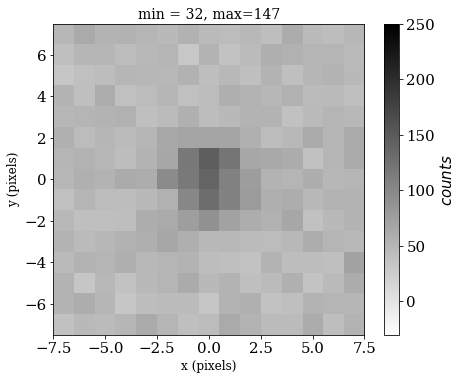

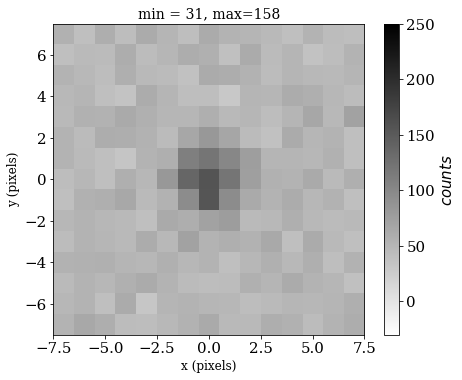

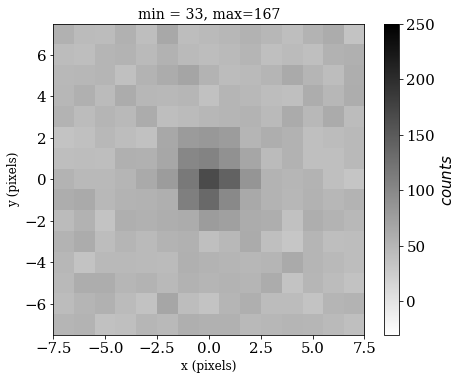

In [4]:
### Make your three simulated images here
seed1 = 800
seed2 = 1000
seed3 = 1200

image1 = simulatedImage(seed1)
image2 = simulatedImage(seed2)
image3 = simulatedImage(seed3)

print ("All three seeded images ready.")

plotCutout(image1)
plotCutout(image2)
plotCutout(image3)

### Task 2

In [5]:
def apPhot(image, r = 3, x0=0, y0=0):
    # Compute the aperture magnitude
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image - skyBg
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum(), apPhotImage

Run psfPhot and apPhot on the results of each image, and print the estimated flux.

### Aperture Photometry : Removing SkyBackground and focussing on pixels of the signal and PSF (within set aperture)

A_ap(After Aperture Photometry correction)(r=3) = 984.0
A_ap(After Aperture Photometry correction)(r=3) = 906.0
A_ap(After Aperture Photometry correction)(r=3) = 940.0


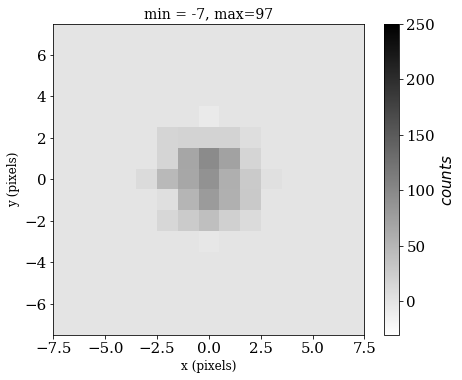

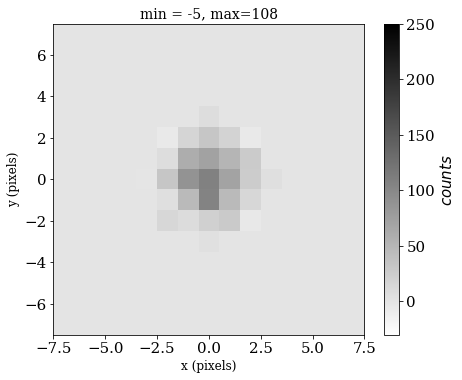

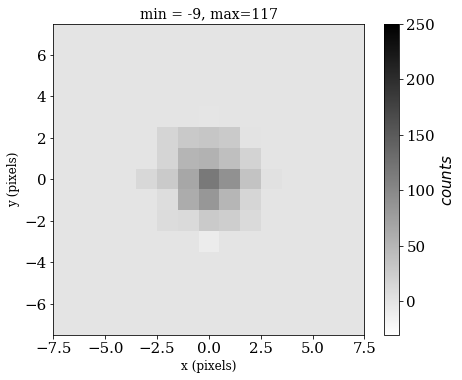

In [6]:
#Aperture Photometry to first concentrate on only those pixels which are in the aperture and not the extra pixels
#Signal + PSF

#apPhot also removes the sky background noise.
#Next concentrating on pixels along aperture. 
r =  3.0                   #aperture radius
count1, apPhotImage1 = apPhot(image1, r)
count2, apPhotImage2 = apPhot(image2, r)
count3, apPhotImage3 = apPhot(image3, r)

plotCutout(apPhotImage1)
print('A_ap(After Aperture Photometry correction)(r=%.0f) = %.1f' % (r, count1))
plotCutout(apPhotImage2)
print('A_ap(After Aperture Photometry correction)(r=%.0f) = %.1f' % (r, count2))
plotCutout(apPhotImage3)
print('A_ap(After Aperture Photometry correction)(r=%.0f) = %.1f' % (r, count3))

### psfPhot : Estimating the ML estimate of the flux within the signal+PSF Pixels

In [7]:
def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)   
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

In [8]:
def psfPhot(image, Amin = 600, Amax = 1400):
    # Estimate the noise in the image
    sigmaNoise = np.sqrt(image)

    # Subtract the background (we assume we've estimated it somehow)
    image = image - skyBg
    

    # search for best flux by gridding
    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best, chi2dof

In [9]:
((bestA1, bestChi2dof1), chi2dof1) = psfPhot(image1, Atrue - 400, Atrue + 400)
print("For Image1: A1_ML = %.1f with chi^2/dof = %.2f" % (bestA1, bestChi2dof1))
((bestA2, bestChi2dof2), chi2dof2) = psfPhot(image2, Atrue - 400, Atrue + 400)
print("For Image2: A2_ML = %.1f with chi^2/dof = %.2f" % (bestA2, bestChi2dof2))
((bestA3, bestChi2dof3), chi2dof3) = psfPhot(image3, Atrue - 400, Atrue + 400)
print("For Image3: A3_ML = %.1f with chi^2/dof = %.2f" % (bestA3, bestChi2dof3))

For Image1: A1_ML = 998.0 with chi^2/dof = 1.22
For Image2: A2_ML = 976.0 with chi^2/dof = 1.15
For Image3: A3_ML = 973.0 with chi^2/dof = 1.14


### Task 2 
Write a function centerPhot that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?

In [10]:
def centerPhot(image):
    #### DEFINE YOUR FUNCTION HERE ####
    #-----This function gives the magnitude(flux) of object as the value of the central pixel of object-----
    dimension = image.shape
    x_dim = dimension[0]
    y_dim = dimension[1]
    x_cent = int(x_dim/2)      
    y_cent = int(y_dim/2)
    imag_null = np.zeros((x_dim, y_dim))
    imag_null[x_cent,y_cent] = 1
    new_image = image*imag_null
    mag_cent = np.nansum(new_image)
    return mag_cent
#NOTE: I Haven't subtracted the skybackground here on purpose, and yet the value is so small.

In [11]:
cent_count1 = centerPhot(image1)
print ("For Image1: Value of central pixel estimated as magnitude of object and is = ", cent_count1)
cent_count2 = centerPhot(image2)
print ("For Image2: Value of central pixel estimated as magnitude of object and is = ", cent_count2)
cent_count3 = centerPhot(image3)
print ("For Image3: Value of central pixel estimated as magnitude of object and is = ", cent_count3)

For Image1: Value of central pixel estimated as magnitude of object and is =  140.0
For Image2: Value of central pixel estimated as magnitude of object and is =  158.0
For Image3: Value of central pixel estimated as magnitude of object and is =  167.0


***Comment on Result***

Naturally, as expected the value of the central pixel is ***<u>much less</u>*** than the value of the flux estimated using say the Aperture Photometry. This is because had the star been observed without any disturbances, we would have obtained the star as a point source and the value of the flux estimated in the central pixel would have been equal to the flux value of the entire object. 
    
    
But this is not so, since, the flux coming from the star is not just concentrated in the central pixel, but is distributed over the PSF. Aperture photometry takes this radius corresponding to the spread of the PSF into account and hence naturally gives a better estimate than this case. 

### Task 3 

Generate a thousand different simulated images using simulatedImage, and compute centerPhot, psfPhot, and apPhot for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using np.average) and standard deviation (with np.std).

In [12]:
n  = 1000
image    = np.zeros(n)
cent_val = np.zeros(n)
ap_val   = np.zeros(n)
psf_val  = np.zeros(n)

def func_4_all():
    #-----Function to run all the functions to calculate flux through different methods.-----
    seeds = np.arange(0,n)
    for i in range(len(seeds)):
        image    = simulatedImage(seeds[i])
        cent_val[i] = centerPhot(image)
        ap_val[i], img_ap   = apPhot(image)
        (psf_val[i], bestchi2), chi2  = psfPhot(image)
    
func_4_all()

/home/aish/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


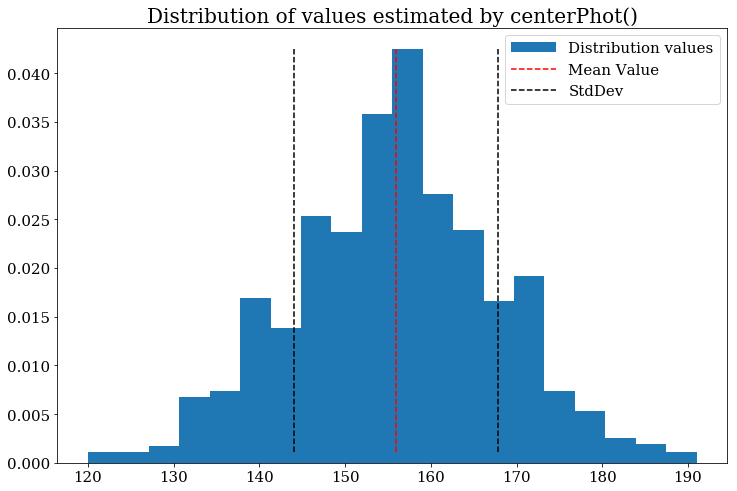

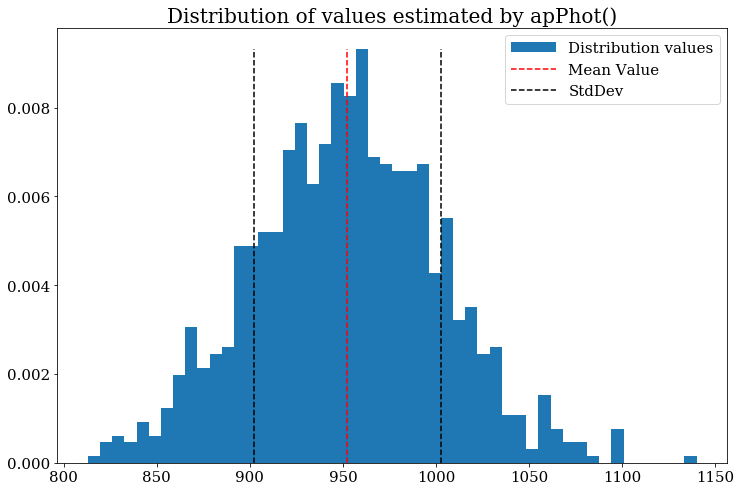

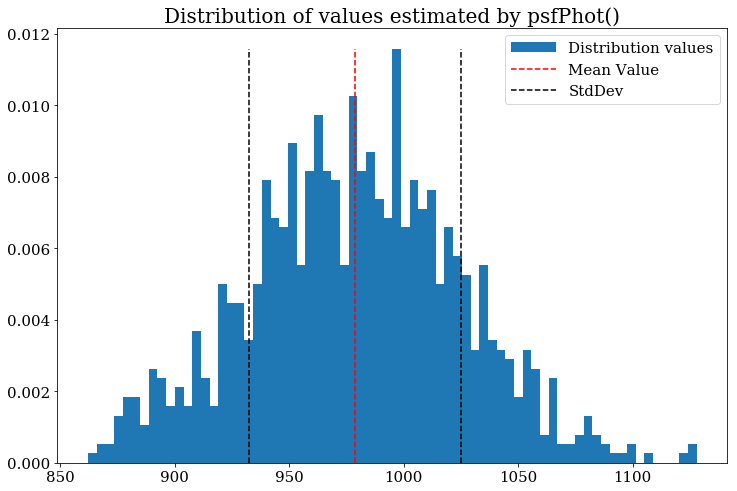

In [13]:
#Central Values
mean_cent_val = np.average(cent_val)
Amean_cent = mean_cent_val
std_cent_val = np.std(cent_val)
fig1 , ax1 = plt.subplots(figsize=(12,8))
y1 = ax1.hist(cent_val, bins = 20, normed = True, label = 'Distribution values' )
plt.vlines(mean_cent_val, np.amin(y1[0]), np.amax(y1[0]), 'r', 'dashed', label = 'Mean Value')
plt.vlines(mean_cent_val-std_cent_val, np.amin(y1[0]), np.amax(y1[0]), 'k', 'dashed', label = 'StdDev')
plt.vlines(mean_cent_val+std_cent_val, np.amin(y1[0]), np.amax(y1[0]), 'k', 'dashed')
ax1.set_title("Distribution of values estimated by centerPhot()", fontsize = 20)
ax1.legend()


#Aperture Values
mean_ap_val = np.average(ap_val)
Amean_ap = mean_ap_val
std_ap_val = np.std(ap_val)
fig2 , ax2 = plt.subplots(figsize=(12,8))
y2 = ax2.hist(ap_val, bins = 50, normed = True, label = 'Distribution values' )
plt.vlines(mean_ap_val, np.amin(y2[0]), np.amax(y2[0]), 'r', 'dashed', label = 'Mean Value')
plt.vlines(mean_ap_val-std_ap_val, np.amin(y2[0]), np.amax(y2[0]), 'k', 'dashed', label = 'StdDev')
plt.vlines(mean_ap_val+std_ap_val, np.amin(y2[0]), np.amax(y2[0]), 'k', 'dashed')
ax2.set_title("Distribution of values estimated by apPhot()", fontsize = 20)
ax2.legend()


#PSF Values
mean_psf_val = np.average(psf_val)
Amean_psf = mean_psf_val
std_psf_val = np.std(psf_val)
fig3 , ax3 = plt.subplots(figsize=(12,8))
y3 = ax3.hist(psf_val, bins = 70, normed = True, label = 'Distribution values')
plt.vlines(mean_psf_val, np.amin(y3[0]), np.amax(y3[0]), 'r', 'dashed', label = 'Mean Value')
plt.vlines(mean_psf_val-std_psf_val, np.amin(y3[0]), np.amax(y3[0]), 'k', 'dashed', label = 'StdDev')
plt.vlines(mean_psf_val+std_psf_val, np.amin(y3[0]), np.amax(y3[0]), 'k', 'dashed')
ax3.set_title("Distribution of values estimated by psfPhot()", fontsize = 20)
ax3.legend()

### Task 4

Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by Atrue/Amean (where Amean is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

/home/aish/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


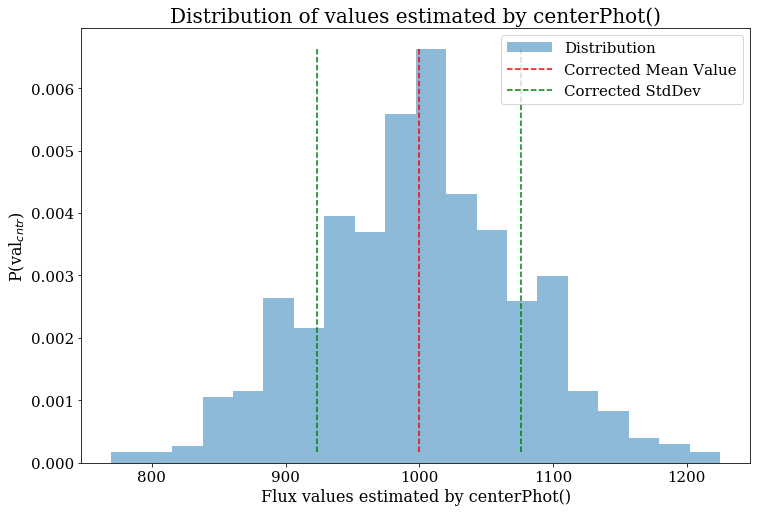

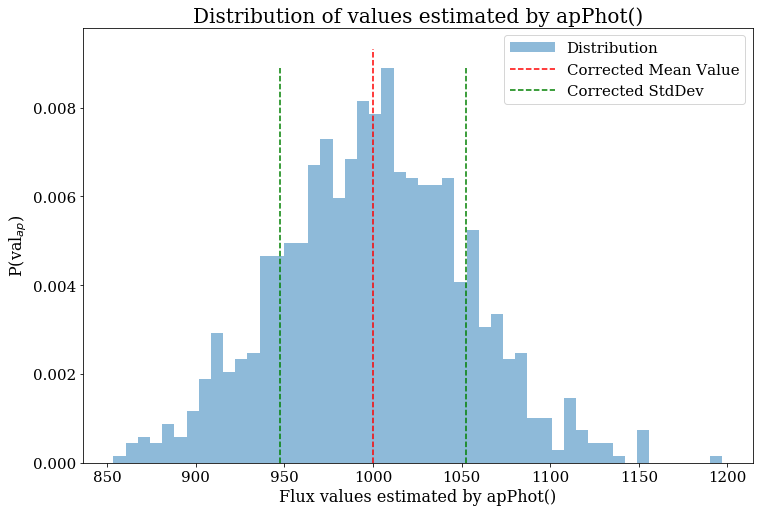

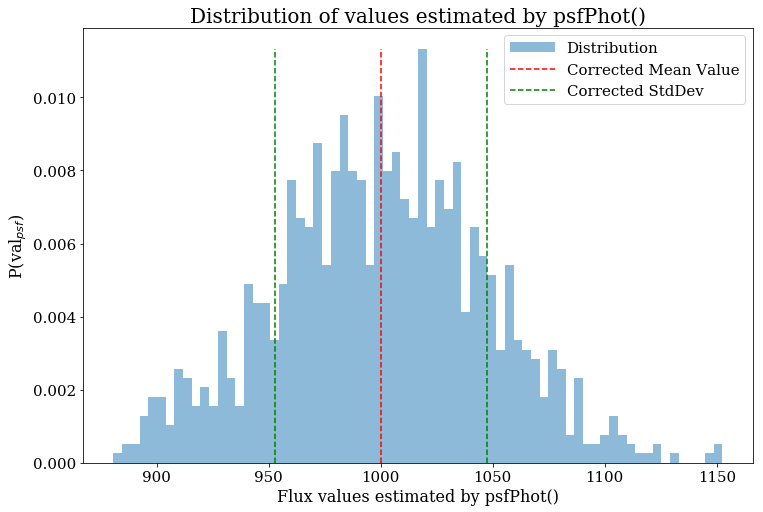

In [14]:
#Central Values
cent_val_corr = cent_val*(Atrue/Amean_cent)
Amean_cent_corr = np.average(cent_val_corr)
std_cent_corr = np.std(cent_val_corr)

fig1 , ax1 = plt.subplots(figsize=(12,8))
y1_corr = ax1.hist(cent_val_corr, bins = 20, normed = True, alpha = 0.5, label = 'Distribution' )
plt.vlines(Amean_cent_corr, np.amin(y1_corr[0]), np.amax(y1_corr[0]), 'r', 'dashed', label = 'Corrected Mean Value')
plt.vlines(Amean_cent_corr-std_cent_corr, np.amin(y1_corr[0]), np.amax(y1_corr[0]), 'g', 'dashed', label = 'Corrected StdDev')
plt.vlines(Amean_cent_corr+std_cent_corr, np.amin(y1_corr[0]), np.amax(y1_corr[0]), 'g', 'dashed')
ax1.set_title("Distribution of values estimated by centerPhot()", fontsize = 20)
ax1.set_xlabel("Flux values estimated by centerPhot()", fontsize = 16)
ax1.set_ylabel("P(val$_{cntr}$)", fontsize = 16)
ax1.legend()


#Aperture Values
ap_val_corr = ap_val*(Atrue/Amean_ap)
Amean_ap_corr = np.average(ap_val_corr)
std_ap_corr = np.std(ap_val_corr)

fig2 , ax2 = plt.subplots(figsize=(12,8))
y2_corr = ax2.hist(ap_val_corr, bins = 50, normed = True, alpha = 0.5, label = 'Distribution' )
plt.vlines(Amean_ap_corr, np.amin(y2_corr[0]), np.amax(y2[0]), 'r', 'dashed', label = 'Corrected Mean Value')
plt.vlines(Amean_ap_corr-std_ap_corr, np.amin(y2_corr[0]), np.amax(y2_corr[0]), 'g', 'dashed', label = 'Corrected StdDev')
plt.vlines(Amean_ap_corr+std_ap_corr, np.amin(y2_corr[0]), np.amax(y2_corr[0]), 'g', 'dashed')
ax2.set_title("Distribution of values estimated by apPhot()", fontsize = 20)
ax2.set_xlabel("Flux values estimated by apPhot()", fontsize = 16)
ax2.set_ylabel("P(val$_{ap}$)", fontsize = 16)
ax2.legend()


#PSF Values
psf_val_corr = psf_val*(Atrue/Amean_psf)
Amean_psf_corr = np.average(psf_val_corr)
std_psf_corr = np.std(psf_val_corr)

fig3 , ax3 = plt.subplots(figsize=(12,8))
y3_corr = ax3.hist(psf_val_corr, bins = 70, normed = True,alpha = 0.5,  label = 'Distribution')
plt.vlines(Amean_psf_corr, np.amin(y3_corr[0]), np.amax(y3_corr[0]), 'r', 'dashed', label = 'Corrected Mean Value')
plt.vlines(Amean_psf_corr-std_psf_corr, np.amin(y3_corr[0]), np.amax(y3_corr[0]), 'g', 'dashed', label = 'Corrected StdDev')
plt.vlines(Amean_psf_corr+std_psf_corr, np.amin(y3_corr[0]), np.amax(y3_corr[0]), 'g', 'dashed')
ax3.set_title("Distribution of values estimated by psfPhot()", fontsize = 20)
ax3.set_xlabel("Flux values estimated by psfPhot()", fontsize = 16)
ax3.set_ylabel("P(val$_{psf}$)", fontsize = 16)
ax3.legend()


### What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

In [15]:
#NOTE I had defined bins so I will compare the three std deviations to answer this question.

print ("Std Dev of corrected data by centerPhot():", std_cent_corr)
print ("Std Dev of corrected data by apPhot():", std_ap_corr)
print ("Std Dev of corrected data by psfPhot():", std_psf_corr)

Std Dev of corrected data by centerPhot(): 76.43453893736246
Std Dev of corrected data by apPhot(): 52.584423479262696
Std Dev of corrected data by psfPhot(): 47.26811856239984


COMMENT ON RESULT:

***As can be seen, I obtain the lowest standard deviation for the <u>psfPhot()</u> method. This means, that this is the best method for Photometry since it gives the least error(std dev).***

***Also this makes sense, because, psfPhotometry has additional steps to account for image processing.***

### Finito
Submitted on: 15.10.2018.